<a href="https://colab.research.google.com/github/CristianRiquelmeF/Scoring-Crediticio-con-Regularizacion/blob/main/Scoring_Crediticio_con_Regularizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> **Objetivo:**
Desarrollar un modelo predictivo para el scoring crediticio, evaluando su rendimiento y la capacidad de interpretación de sus decisiones.

- Utilizando un dataset sobre historial crediticio, el proyecto tiene como objetivo predecir si un cliente tiene alto riesgo crediticio (objetivo binario).


- Se deben utilizar técnicas de regularización (como Lasso o Ridge) para construir el modelo predictivo.

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, roc_curve)
from sklearn.linear_model import LogisticRegression
import seaborn as sns




**Carga dataset y revisión preliminar**

In [ ]:
# Cargar el dataset "credit"
df = fetch_openml("credit", version=1)
X = df.data
y = df.target

In [ ]:
# Convertir a DataFrame para exploración
df = pd.DataFrame(X, columns=df.feature_names)
df['riesgo'] = y

# Ver las primeras filas
df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,riesgo
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0.0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0.0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0.0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0.0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
print("Cantidad de filas:")
display(df.shape[0])
print("")
print("Número de columnas:")
display(df.shape[1])

Cantidad de filas:


16714


Número de columnas:


11

In [ ]:
# Revisión del contenido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  16714 non-null  float64
 1   age                                   16714 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  16714 non-null  float64
 3   DebtRatio                             16714 non-null  float64
 4   MonthlyIncome                         16714 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       16714 non-null  float64
 6   NumberOfTimes90DaysLate               16714 non-null  float64
 7   NumberRealEstateLoansOrLines          16714 non-null  float64
 8   NumberOfTime60-89DaysPastDueNotWorse  16714 non-null  float64
 9   NumberOfDependents                    16714 non-null  float64
 10  riesgo                                16714 non-null  float64
dtypes: float64(11)


| Nº | Columna                                | Tipo      | Descripción (estimada por nombre)                     |
| -- | -------------------------------------- | --------- | ----------------------------------------------------- |
| 0  | `RevolvingUtilizationOfUnsecuredLines` | `float64` | Proporción de crédito usado vs. disponible (0–1)      |
| 1  | `age`                                  | `float64` | Edad del solicitante                                  |
| 2  | `NumberOfTime30-59DaysPastDueNotWorse` | `float64` | Número de veces con mora de 30-59 días                |
| 3  | `DebtRatio`                            | `float64` | Proporción deuda / ingresos                           |
| 4  | `MonthlyIncome`                        | `float64` | Ingreso mensual (puede tener outliers)                |
| 5  | `NumberOfOpenCreditLinesAndLoans`      | `float64` | Cantidad de créditos/líneas activas                   |
| 6  | `NumberOfTimes90DaysLate`              | `float64` | Número de veces con mora de 90+ días                  |
| 7  | `NumberRealEstateLoansOrLines`         | `float64` | Cantidad de hipotecas u otros préstamos inmobiliarios |
| 8  | `NumberOfTime60-89DaysPastDueNotWorse` | `float64` | Número de veces con mora de 60-89 días                |
| 9  | `NumberOfDependents`                   | `float64` | Número de dependientes económicos                     |
| 10 | `riesgo`                             | `float64` | **Variable objetivo**: 1 si , 0  no     |


- En este dataset la variable objetivo 'riesgo', representa riesgo crediticio del cliente: 1 = Sí, 0 = No

In [ ]:
# Conteo de clases en variable objetivo
df['riesgo'].value_counts()

,count
riesgo,
0.0,8357
1.0,8357


**Variables clave:**

- Comportamiento de pagos (NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate)

- Situación financiera (DebtRatio, MonthlyIncome)

- Historial crediticio (NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines)

In [ ]:
df.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,riesgo
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000
mean,4.799862,48.798672,1.110267,30.980298,6118.120258,8.503709,0.863827,1.047445,0.734354,0.944358,0.500000
std,204.062345,13.906078,7.172890,719.694859,5931.841779,5.370965,7.167576,1.272565,7.138737,1.198791,0.500015
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082397,38.000000,0.000000,0.155971,3128.500000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.443080,48.000000,0.000000,0.322299,5000.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.500000
75%,0.926637,58.000000,1.000000,0.533426,7573.000000,11.000000,0.000000,2.000000,0.000000,2.000000,1.000000
max,22000.000000,101.000000,98.000000,61106.500000,250000.000000,57.000000,98.000000,29.000000,98.000000,8.000000,1.000000


In [ ]:
# Observación de valores nulos
df.isnull().sum()

,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,0
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0
NumberOfDependents,0


In [ ]:
# Revisión valores duplicados
df.duplicated().sum()

np.int64(2)

In [ ]:
# Revisión de filas duplicadas
duplicated_rows = df[df.duplicated(keep=False)]  # `keep=False` marca TODOS los duplicados (incluyendo el primero)
duplicated_rows.sort_values(by=list(df.columns))  # Ordena para verlos agrupados

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,riesgo
10133,1.0,22.0,98.0,0.0,0.0,0.0,98.0,0.0,98.0,0.0,1.0
11054,1.0,22.0,98.0,0.0,0.0,0.0,98.0,0.0,98.0,0.0,1.0
11673,1.0,55.0,0.0,0.0,1000.0,0.0,1.0,0.0,0.0,0.0,1.0
12257,1.0,55.0,0.0,0.0,1000.0,0.0,1.0,0.0,0.0,0.0,1.0


/tmp/ipython-input-41-1291960022.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, color='teal', rug=True)


Text(0.5, 0, 'Edad')

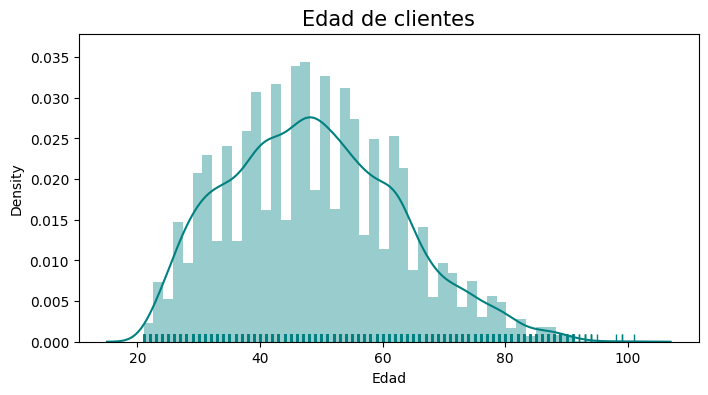

In [ ]:
# Gráfica de la distribución edades
plt.figure(figsize=(8,4))
x = df['age']
plt.title('Edad de clientes', fontsize=15)
ax = sns.distplot(x, color='teal', rug=True)
plt.xlabel('Edad')

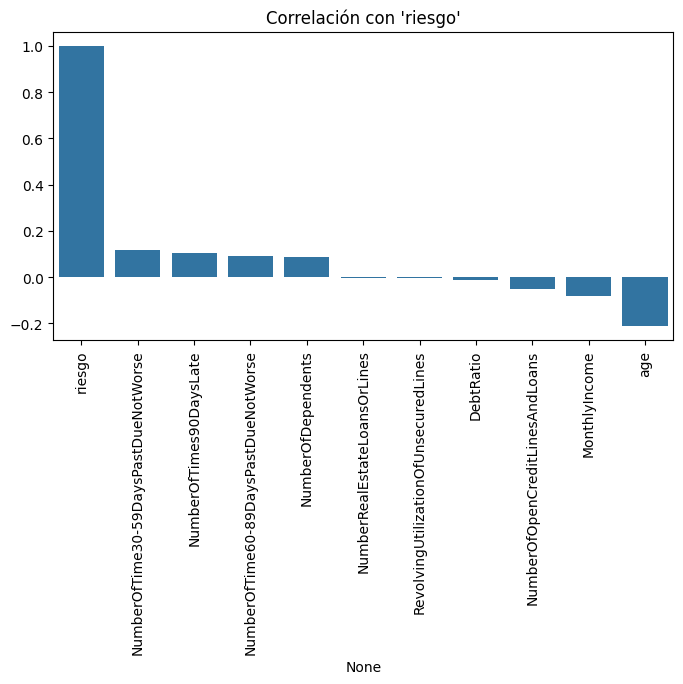

In [ ]:
# Correlación con el target
corr_with_target = df.corr()['riesgo'].sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.xticks(rotation=90)
plt.title("Correlación con 'riesgo'")
plt.show()

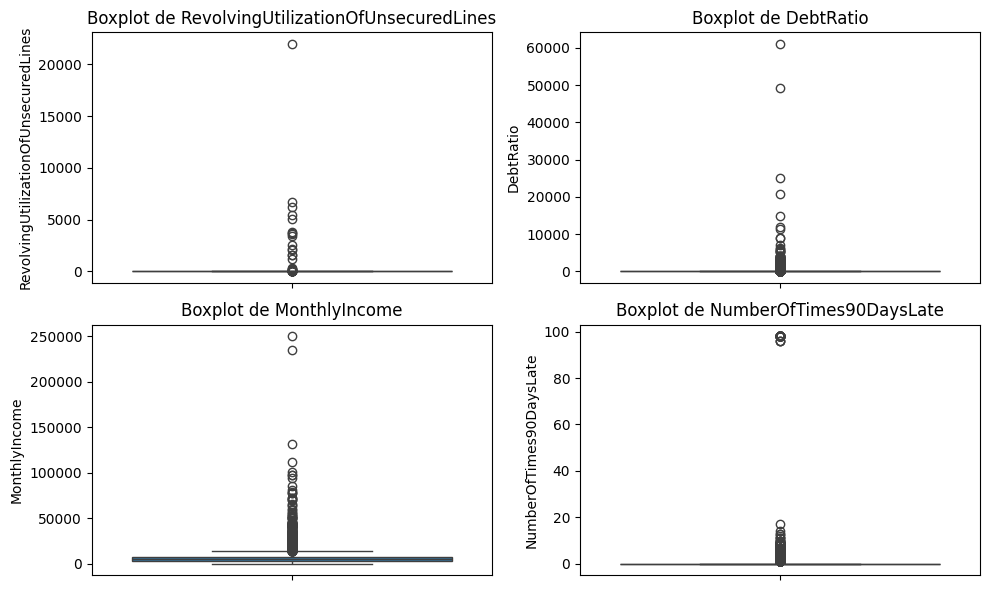

In [ ]:
# Outliers en variables clave
outlier_vars = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfTimes90DaysLate'
]

plt.figure(figsize=(10, 6))
for i, col in enumerate(outlier_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

**Preprocesamiento**

In [ ]:
# Convertir de float a entero para evitar problemas en modelos de clasificación en ML.
y = y.astype(int)

In [ ]:
# Copia de X para aplicar tratamiento de outliers
X_pre = X.copy()

In [ ]:
# Tratamiento de outliers antes de escalar, afectan desempeño en regresión logística.
cols_to_clip = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'NumberOfTimes90DaysLate']
X_pre[cols_to_clip] = X_pre[cols_to_clip].apply(lambda x: x.clip(upper=x.quantile(0.99)))

In [ ]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Escalar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Entrenamiento del modelos**

In [ ]:
# Función de evaluación
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    print(f"\n--- {nombre} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print("\n", classification_report(y_test, y_pred))

**Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluar_modelo("Random Forest", rf, X_test, y_test)


--- Random Forest ---
Accuracy: 0.7759497457373616
Precision: 0.7744047619047619
Recall: 0.7785757031717534
F1-Score: 0.7764846314532975
AUC-ROC: 0.8521247269062161

               precision    recall  f1-score   support

           0       0.78      0.77      0.78      1672
           1       0.77      0.78      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



**Regresión logística sin regularización**

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (sin regularización)", logreg, X_test, y_test)


--- Logistic Regression (sin regularización) ---
Accuracy: 0.759796589889321
Precision: 0.7699004975124378
Recall: 0.7408737283064033
F1-Score: 0.755108264714852
AUC-ROC: 0.8423407752284252

               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



**Regresión Lasso (L1)**

In [ ]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
lasso.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (Lasso - L1)", lasso, X_test, y_test)


--- Logistic Regression (Lasso - L1) ---
Accuracy: 0.7606939874364343
Precision: 0.7713395638629283
Recall: 0.7408737283064033
F1-Score: 0.7557997557997558
AUC-ROC: 0.8425812981940735

               precision    recall  f1-score   support

           0       0.75      0.78      0.77      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



**Regresión Ridge (L2)**

In [ ]:
ridge = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
ridge.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (Ridge - L2)", ridge, X_test, y_test)


--- Logistic Regression (Ridge - L2) ---
Accuracy: 0.759796589889321
Precision: 0.7699004975124378
Recall: 0.7408737283064033
F1-Score: 0.755108264714852
AUC-ROC: 0.8423407752284252

               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



**Regresión Elastic Net**

In [ ]:
elastic = LogisticRegression(penalty='elasticnet', solver='saga',
                                   l1_ratio=0.5, max_iter=1000, random_state=42)
elastic.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (Elastic Net)", elastic, X_test, y_test)


--- Logistic Regression (Elastic Net) ---
Accuracy: 0.759796589889321
Precision: 0.7699004975124378
Recall: 0.7408737283064033
F1-Score: 0.755108264714852
AUC-ROC: 0.8425000501089512

               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



**Gráficos que muestran la importancia de las características y cómo impactan las predicciones.**

/tmp/ipython-input-53-2534457768.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia_rf, x='Importancia', y='Feature', palette='viridis')


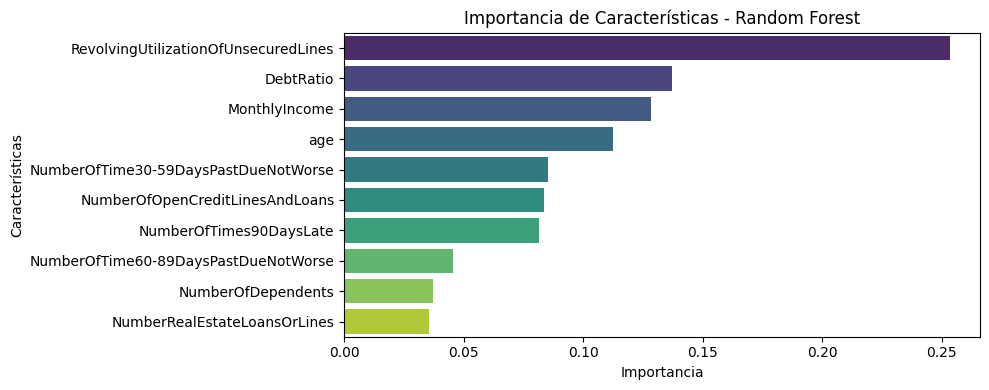

In [ ]:
# Obtener importancias del modelo Random Forest
importancias = rf.feature_importances_
features = X.columns

# Crear dataframe ordenado
df_importancia_rf = pd.DataFrame({
    'Feature': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(data=df_importancia_rf, x='Importancia', y='Feature', palette='viridis')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()


In [ ]:
# Función de visualización para regresiones
def plot_coef(modelo, feature_names, nombre_modelo="Regresión"):
    """
    Parámetros:
    - modelo: modelo entrenado (con atributo .coef_)
    - feature_names: lista con nombres de las características
    - nombre_modelo: título para el gráfico
    """
    # Extraer coeficientes
    coefs = modelo.coef_[0] if len(modelo.coef_.shape) > 1 else modelo.coef_
    # Crear DataFrame ordenado
    df_coef = pd.DataFrame({
        'Feature': feature_names,
        'Coeficiente': coefs
    }).sort_values(by='Coeficiente', key=abs, ascending=False)
    # Graficar
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')
    plt.title(f'Impacto de Características - {nombre_modelo}')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()


- Los coeficientes del modelo indican la influencia de cada variable. Por ejemplo, en este caso, un coeficiente positivo implica que un aumento en esa variable aumenta la probabilidad de desaprobación, que el cliente posee riesgo crediticio.
- "Número de veces que el cliente tuvo pagos con 30-59 días de atraso" (sin llegar a mora grave).	Valores altos sugieren riesgo crediticio.
- "Número de veces que el cliente tuvo pagos con +90 días de atraso".	Indicador fuerte de morosidad grave.

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


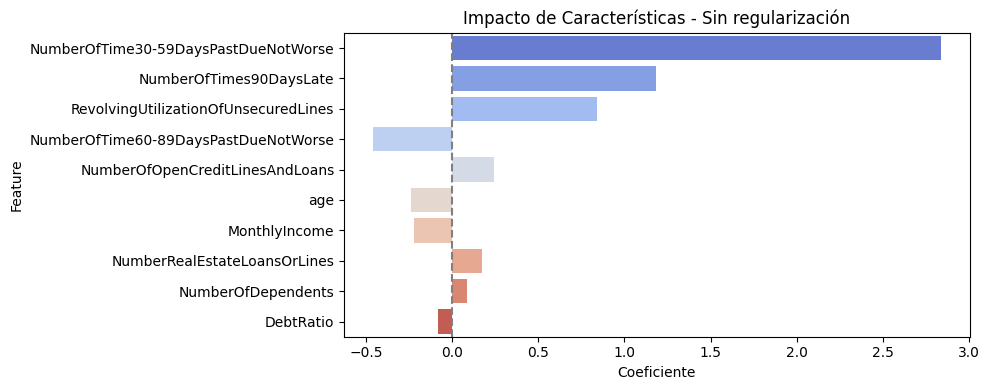

In [ ]:
plot_coef(logreg, X.columns, "Sin regularización")

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


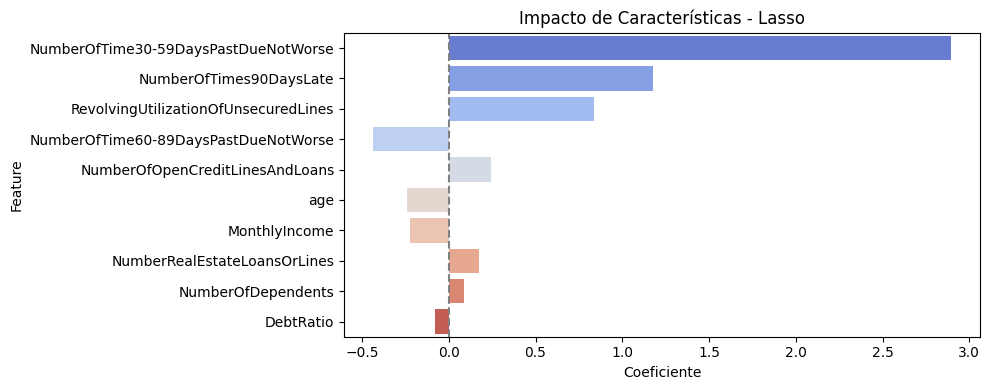

In [ ]:
plot_coef(lasso, X.columns, "Lasso")

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


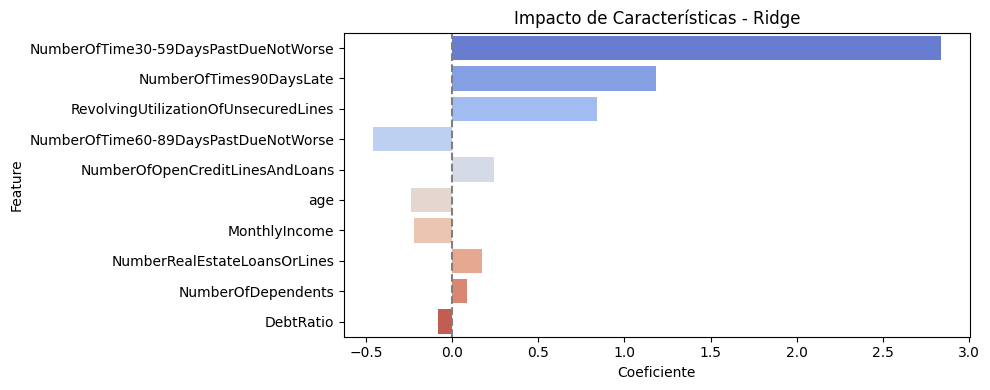

In [ ]:
plot_coef(ridge, X.columns, "Ridge")

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


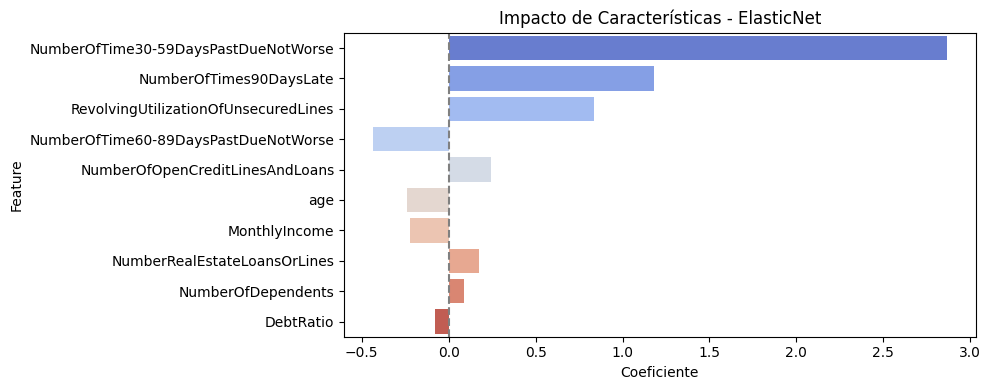

In [ ]:
plot_coef(elastic, X.columns, "ElasticNet")

**Análisis Comparativo de Modelos de Regresión Logística**

In [ ]:
#Recolectar métricas de los modelos
def get_metrics(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

In [ ]:
#Obtener métricas para cada modelo
metrics_reglog = get_metrics("Regresión Logística", logreg, X_test, y_test)
metrics_lasso = get_metrics("Regresión Logística Lasso ", lasso, X_test, y_test)
metrics_ridge = get_metrics("Regresión Logística Ridge", ridge, X_test, y_test)
metrics_elastic = get_metrics("Regresión Logística Elastic Net", elastic, X_test, y_test)
#Crear DataFrame con los resultados
result = pd.DataFrame([metrics_reglog, metrics_lasso,metrics_ridge,metrics_elastic])

In [ ]:
result

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Regresión Logística,0.759797,0.76990,0.740874,0.755108,0.842341
1,Regresión Logística Lasso,0.760694,0.77134,0.740874,0.755800,0.842581
2,Regresión Logística Ridge,0.759797,0.76990,0.740874,0.755108,0.842341
3,Regresión Logística Elastic Net,0.759797,0.76990,0.740874,0.755108,0.842500


Entre las 4 técnicas empleadas en el proyecto se puede observar que:
1. Todos los modelos tienen métricas muy cercanas, lo que sugiere que la regularización no está teniendo un impacto significativo en este dataset. Esto puede deberse a bajo overfitting, es decir, los datos ya son linealmente separables o no tienen ruido excesivo. En este dataset la variable objetivo está dividida de manera balanceada 50/50.

2. Mejor Modelo:
Regresión Logística con Lasso (L1) obtuvo:

  - Mayor Accuracy (0.7606) y F1-Score (0.7558).

   - AUC-ROC ligeramente más alta (0.8425).

   - Precisión más alta (0.7713) sin sacrificar recall.
3.  Lasso tiende a hacer selección de características automáticamente, lo que mejora la interpretabilidad y reduce sobreajuste.

**Análisis comparativo de Regresión Logística Lasso (mejor entre las regresiones) y Random Forest**

In [ ]:
#Obtener métricas para cada modelo
metrics_rf = get_metrics("Random Forest", rf, X_test, y_test)
metrics_lasso = get_metrics("Regresión Logística Lasso ", lasso, X_test, y_test)
#Crear DataFrame con los resultados
result2 = pd.DataFrame([metrics_rf, metrics_lasso])

In [ ]:
result2

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,0.775950,0.774405,0.778576,0.776485,0.852125
1,Regresión Logística Lasso,0.760694,0.771340,0.740874,0.755800,0.842581


**Conclusión**

- Random Forest supera en todas las métricas al modelo de regresión logística con Lasso:

  - Tiene mejor capacidad de generalización (mayor AUC).

  - Muestra mejor equilibrio entre precisión y recall.
  - La diferencia en AUC-ROC y Recall justifica la elección del modelo basado en árboles.

  - Funciona bien sin necesidad de escalar los datos o asumir relaciones lineales.
-La interpretabilidad del modelo, en el contexto del dataset analizado, es fundamental en casos donde se le niega un crédito a un cliente, ya que este debe poder comprender los motivos de la decisión, y la empresa debe estar en condiciones de justificarla de manera clara y objetiva.
- La regresión logística (con o sin regularización) permite ver coeficientes positivos o negativos y cómo cada variable afecta la probabilidad de aprobación.

- Random Forest es más preciso, pero menos explicativo sin herramientas adicionales como SHAP o Permutation Importance.